In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD

In [ ]:
movies = pd.read_csv("movies.csv")

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [ ]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
tfidf = TfidfVectorizer(stop_words="english")
movies_tfidf = tfidf.fit_transform(movies["genres"])

In [ ]:
wcss = []
k_range = range(1, 13)

In [ ]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=28)
    kmeans.fit(movies_tfidf)
    wcss.append(kmeans.inertia_)

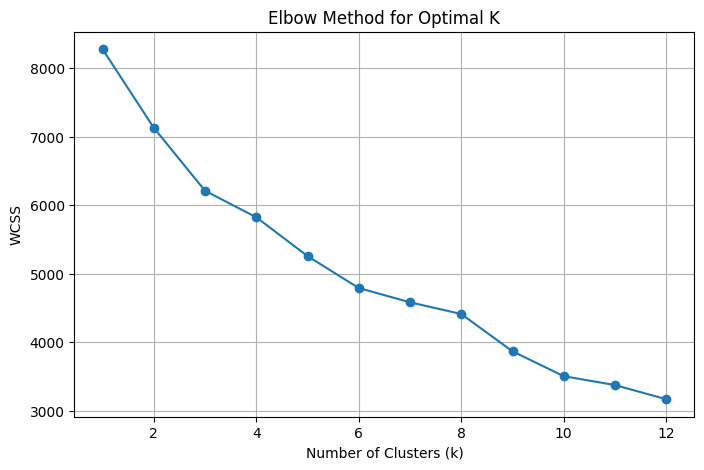

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [ ]:
for k in range(2, 13):
    km = KMeans(n_clusters=k, random_state=28)
    labels = km.fit_predict(movies_tfidf)
    score = silhouette_score(movies_tfidf, labels)
    print(f"k={k}, silhouette score={score:.4f}")

k=2, silhouette score=0.1596
k=3, silhouette score=0.2050
k=4, silhouette score=0.2044
k=5, silhouette score=0.2565
k=6, silhouette score=0.2915
k=7, silhouette score=0.3053
k=8, silhouette score=0.3102
k=9, silhouette score=0.3563
k=10, silhouette score=0.3818
k=11, silhouette score=0.3874
k=12, silhouette score=0.3941


In [ ]:
k = 10  # chosen ideal number of clusters
kmeans = KMeans(n_clusters=10, random_state=28)
movies["cluster"] = kmeans.fit_predict(movies_tfidf)

In [ ]:
movies.head()

,movieId,title,genres,cluster
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,8
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,8
4,5,Father of the Bride Part II (1995),Comedy,6


In [ ]:
def recommend_movie(movie_title, top_n=10):
    idx = movies[movies["title"].str.contains(movie_title, case=False)].index[0]

    movie_cluster = movies.loc[idx, "cluster"]

    cluster_indices = movies[movies["cluster"] == movie_cluster].index

    similarity = cosine_similarity(
        movies_tfidf[idx], # type: ignore
        movies_tfidf[cluster_indices],  # type: ignore
    ).flatten()

    similar_indices = cluster_indices[similarity.argsort()[-top_n - 1 : -1][::-1]]

    return movies.loc[similar_indices, ["title", "genres"]]

In [ ]:
recommend_movie("Toy Story")

,title,genres
3811,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
7382,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
6997,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
7987,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
10052,"Boxtrolls, The (2014)",Adventure|Animation|Children|Comedy|Fantasy
1815,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2496,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
9215,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
3166,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
svd = TruncatedSVD(n_components=2, random_state=28)
tfidf_2d = svd.fit_transform(movies_tfidf)

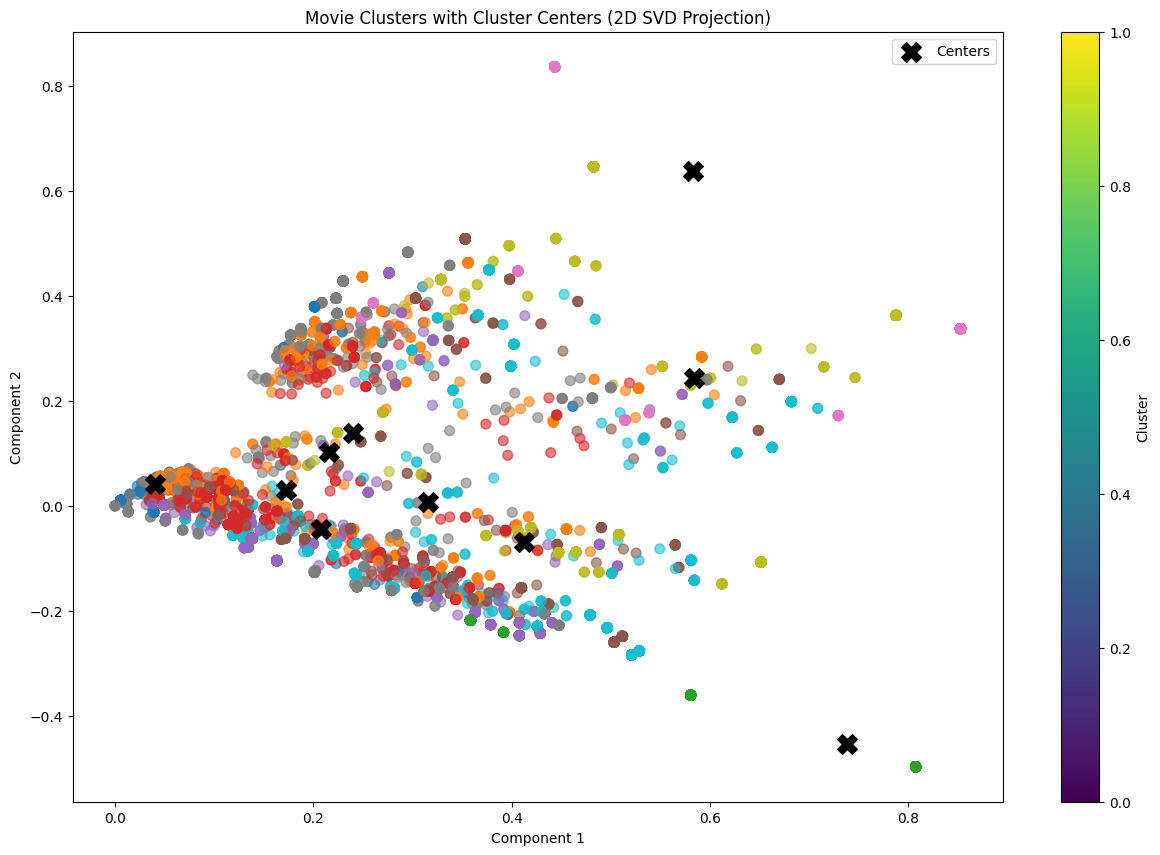

In [ ]:
plt.figure(figsize=(15, 10))

plt.scatter(
    tfidf_2d[:, 0], tfidf_2d[:, 1], c=movies["cluster"], cmap="tab10", s=50, alpha=0.6
)

# Project cluster centers correctly
centers_2d = svd.transform(kmeans.cluster_centers_)
plt.scatter(
    centers_2d[:, 0], centers_2d[:, 1], c="black", s=200, marker="X", label="Centers"
)

plt.title("Movie Clusters with Cluster Centers (2D SVD Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.legend()
plt.show()